In [3]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee
import corner

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


### Load inputs

In [4]:
xvalO = np.load("../GP_Paper/xvalO.npy")
yvalO = np.load("../GP_Paper/yvalO.npy")
xerrO = np.load("../GP_Paper/xerrO.npy")
xlowO = np.load("../GP_Paper/xlowO.npy")
xval = np.load("../GP_Paper/xval.npy")
yval = np.load("../GP_Paper/yval.npy")
xerr = np.load("../GP_Paper/xerr.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

### Plot correlation matrix, log(covariance matrix), and covariance matrix

In [5]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        #ax2.plot(x, 2e6*np.exp(-(x/300)), c='g')
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

#### 3 parameter fit function

In [7]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

#### Poisson likelihood

In [8]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### emcee for 3 parameter fit function
* chi2 likelihood of 3 parameter fit function
* poisson likelihood of 3 parameter fit function
* run emcee on 3 parameter fit function

In [9]:
def logLike_ind(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-yvalO)*(bkgFunc-yvalO) / bkgFunc) 
    

def logLike_3ff_emcee(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xvalO, p, xerrO)       
    logL = 0
    for ibin in range(len(yvalO)):
        data = yvalO[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

#### Run emcee on 3 parameter fit

In [15]:
##CHECK BOTH logLike_ind and logLike_3ff_emcee
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind)
print "I'm done"

Running first burn-in...
Running second burn-in
Running production
I'm done


### Plot distribution of fit function parameter values from posterior sampling 

(36000, 3)
[ 0.01318431  7.86199039 -5.30581689]


NameError: name 'ticker' is not defined

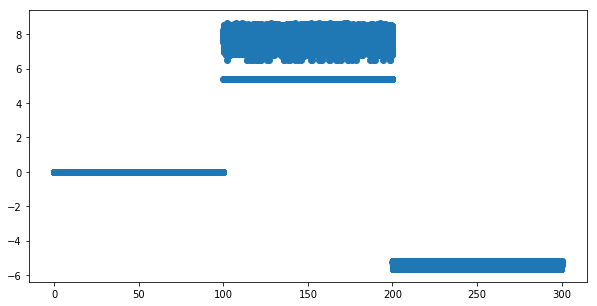

In [16]:
param_values = samples.flatchain
#print sampleset
print param_values.shape
print param_values.mean(axis=0)
### remove
yhist = [param_values[i][0] for i in range(len(param_values))]+[param_values[i][1] for i in range(len(param_values))]+[param_values[i][2] for i in range(len(param_values))]
### 100 x bins for each parameter, staggered to fit in one histogram
binne = len(yhist)/3
xhist1 = list(100*np.random.random(binne))
xhist2 = list(100*np.random.random(binne)+100)
xhist3 = list(100*np.random.random(binne)+200)
xhist = xhist1+xhist2+xhist3


f, ax = plt.subplots(1,  figsize=(10,5))
ax.scatter(xhist, yhist)

# Customize minor tick labels
ax.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax.get_xaxis().set_minor_locator(ticker.FixedLocator([50,150,250]))
ax.get_xaxis().set_minor_formatter(ticker.FixedFormatter(['p0','p1','p2']))
ax.tick_params(axis='x', labelsize=20)
ax.set_ylabel("parameter value")

plt.figure()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw = {'height_ratios':[1, 1, 1]}, figsize=(15,10))
ax1.hist([param_values[i][0] for i in range(len(param_values))], 100)
ax1.set_xlabel("p0")
ax1.set_xlabel("p0")

ax2.hist([param_values[i][1] for i in range(len(param_values))], 100)
ax2.set_xlabel("p1")
ax2.set_xlabel("p1")

ax3.hist([param_values[i][1] for i in range(len(param_values))], 100)
ax3.set_xlabel("p2")
ax3.set_xlabel("p2")

### Create correlation and covaraince matrix from emcee posterior samples

In [17]:
modelMatrix=np.empty([param_values.shape[0], xvalO.size])
for ip, ps in enumerate(param_values):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

### Draw distributions of fit function parameter values vs each other, with mean parameter values drawn in blue

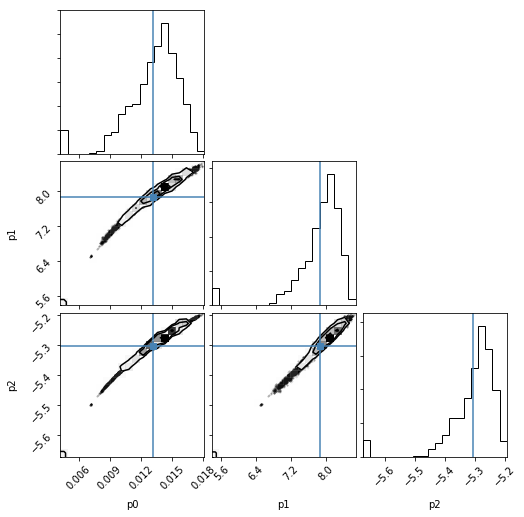

In [18]:
labels = ["p0", "p1", "p2"]
truth = param_values.mean(axis=0)
fig = corner.corner(param_values, truths=truth, labels=labels)


### Draw distribution of counts from fit function posterior samples in first 5 bins of the distribution. Show true data counts in blue

49639.0


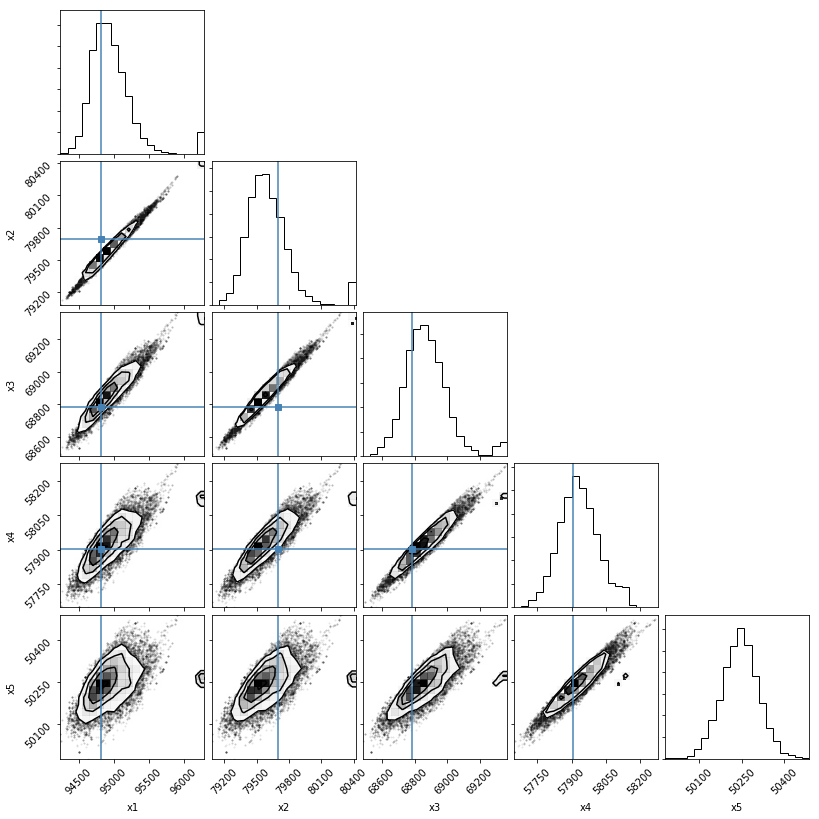

In [19]:
labels = ["x1", "x2", "x3", "x4", "x5"]
truth = yvalO[:5]
print yvalO[4]
fig = corner.corner(modelMatrix[:,:5], truths=truth, labels=labels)

### Draw distribution of counts from fit function posterior samples for every 5 bins in the distribution. Show true data counts in blue

['bin 3', 'bin 8', 'bin 13', 'bin 18', 'bin 23', 'bin 28', 'bin 33', 'bin 38', 'bin 43', 'bin 48', 'bin 53', 'bin 58', 'bin 63', 'bin 68']


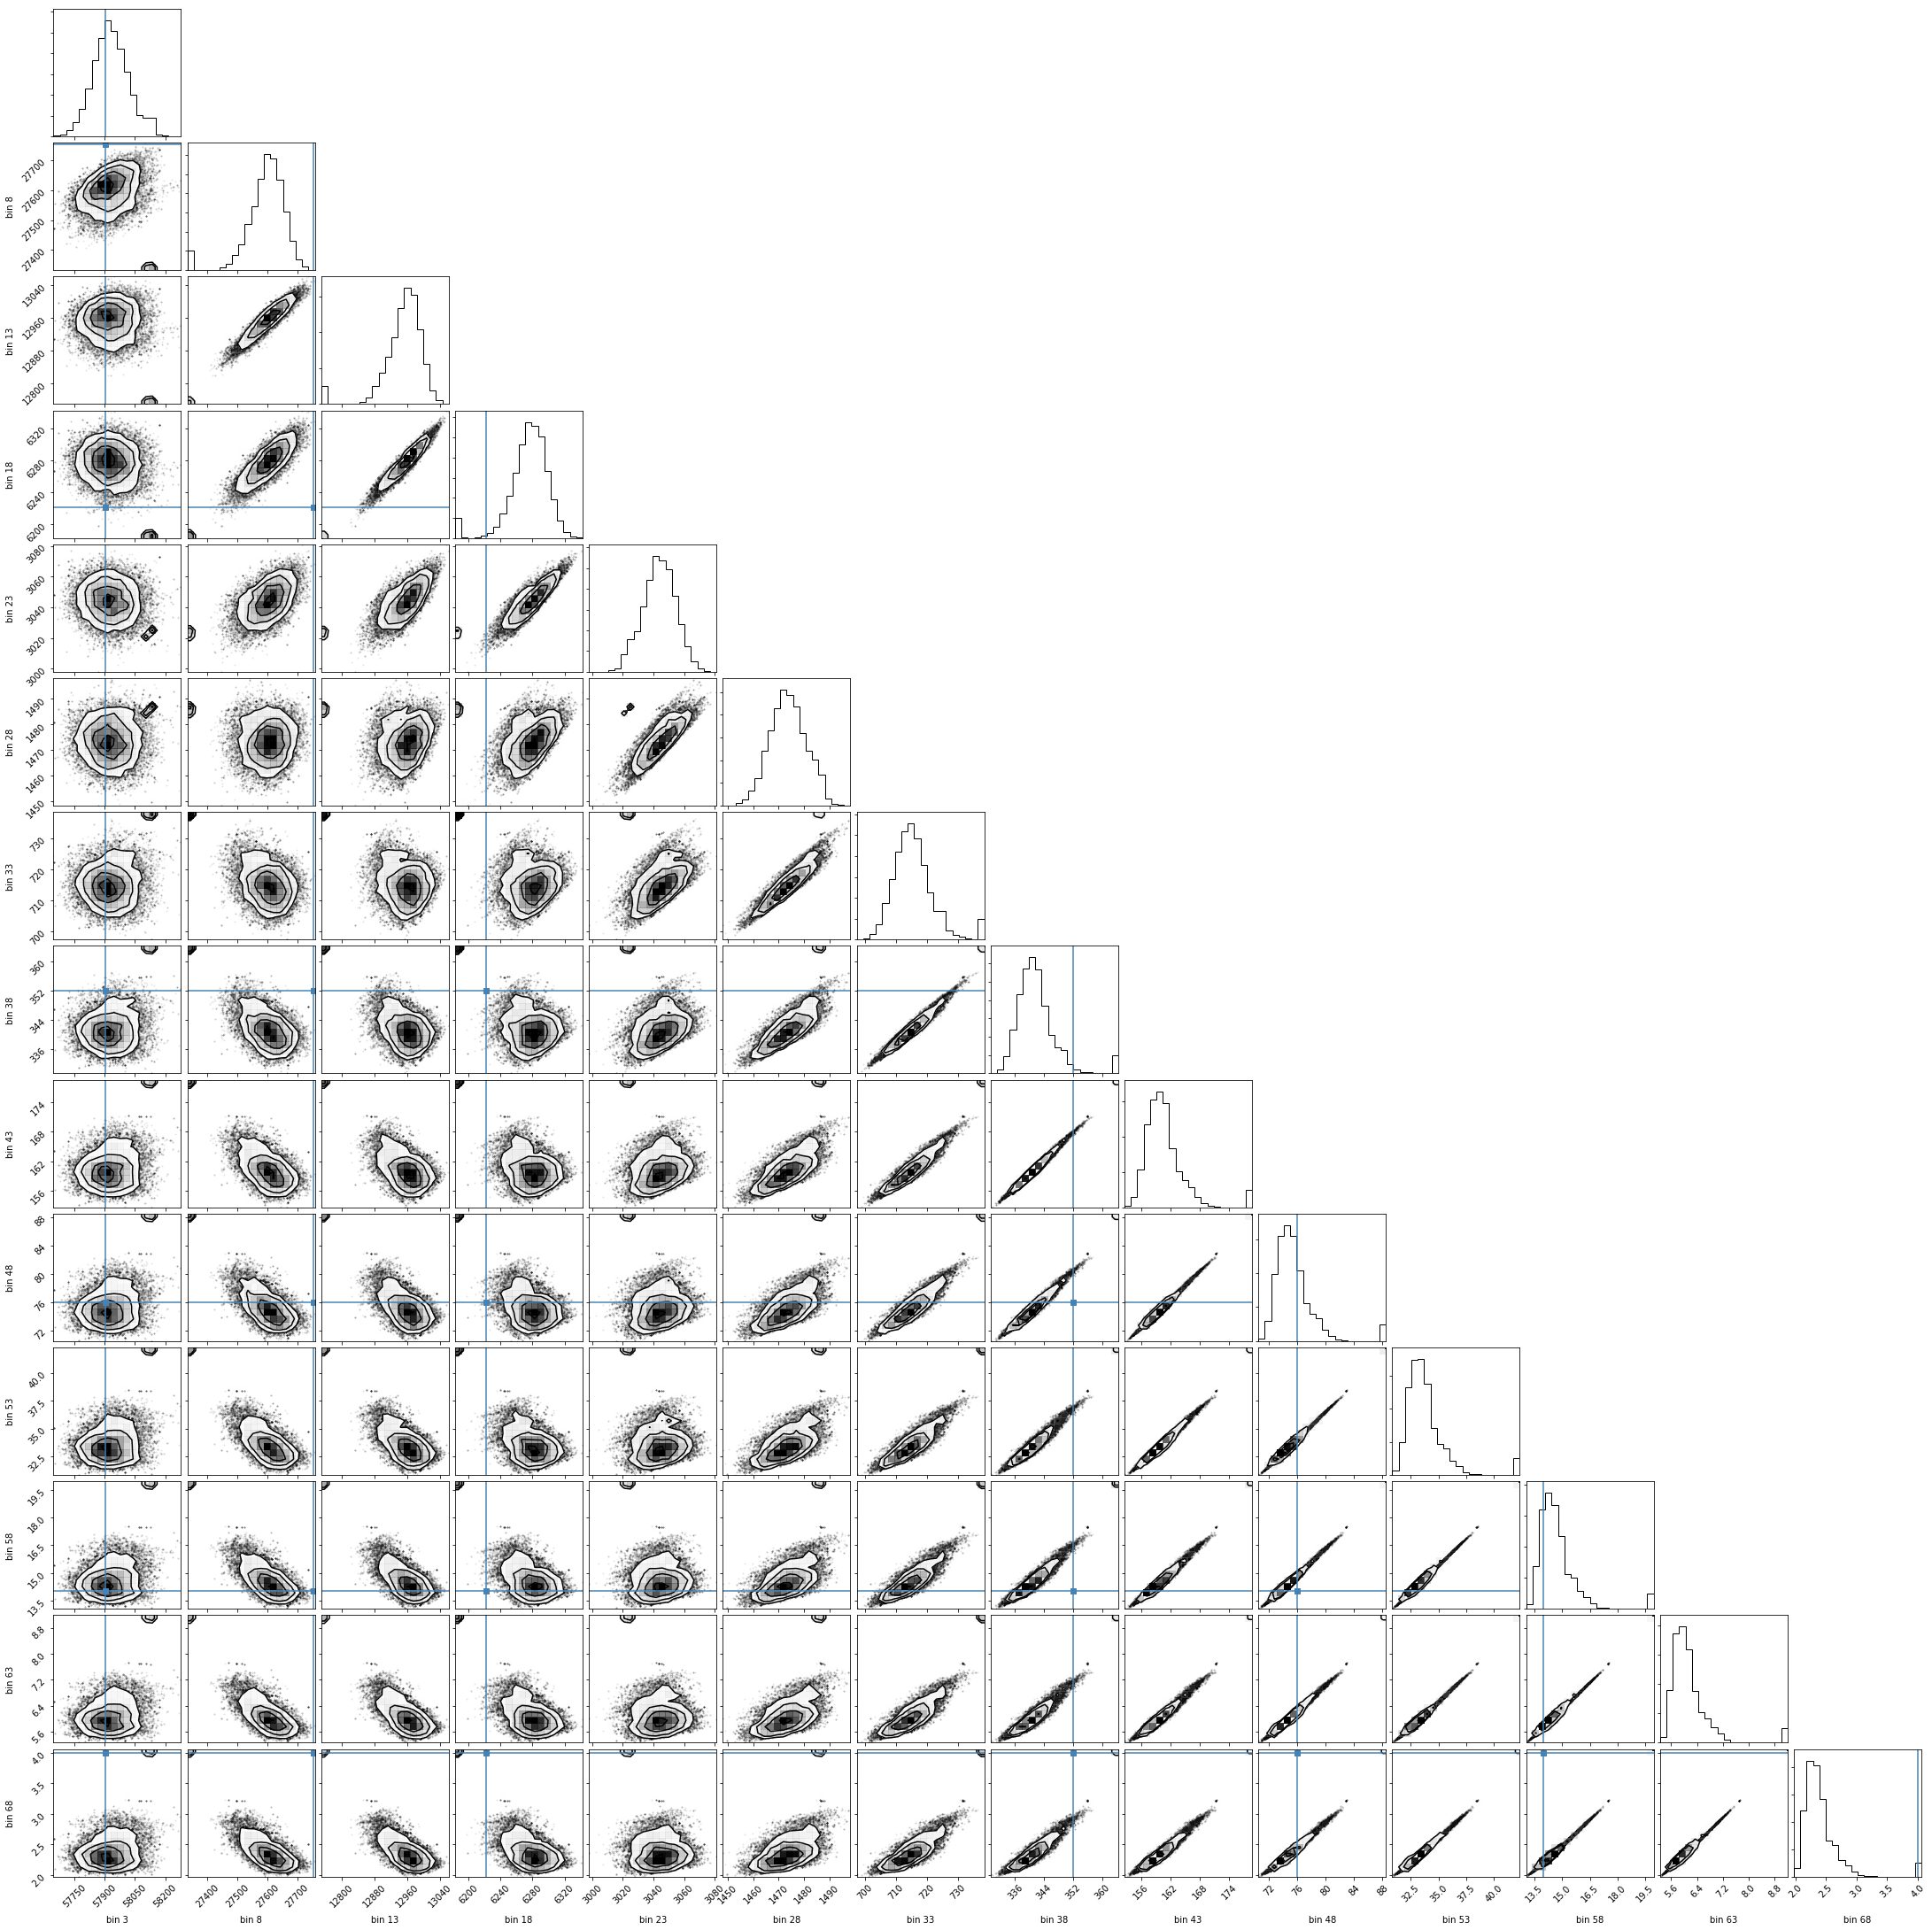

In [20]:
labels=map(str,np.arange(83)[-80:-10:5])
labels = ["bin " + s for s in labels]
print labels
truth = yvalO[-80:-10:5]
fig = corner.corner(modelMatrix[:,-80:-10:5], truths=truth, labels=labels)